In [1]:
# Bibliotecas além do gerenciador Anaconda
!pip install spacy
!python -m spacy download pt_core_news_sm

2022-05-13 08:49:36.558273: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2022-05-13 08:49:36.560396: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



[+] Download and installation successful
You can now load the package via spacy.load('pt_core_news_sm')


In [1]:
# Módulos básicos para manuseio de dados e arquivos
import pandas as pd
import numpy as np
import os
import re
import string
import unicodedata
from os.path import isfile, join

# Módulo para visualização de dados
import matplotlib.pyplot as plt
%matplotlib inline

# Módulos para processamento de linguagem
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

## Carregamento de textos

In [2]:
limited_news_path = r'Software\Fake.br-Corpus' #\fake_10 or \true_10
news_path = r'Software\Fake.br-Corpus\full_texts' #\fake or \true

paths = [limited_news_path, news_path]

In [3]:
def sortDir(dir_path: str, is_meta=False) ->list:
    '''
    Ordena os arquivos dentro de dir_path e os retorna no formato de lista.
    '''
    if is_meta:
        number_separator = "-meta.txt"
    else:
        number_separator = ".txt"

    first_list = os.listdir(dir_path)
    int_list = [int(element.split(number_separator)[0]) for element in first_list]
    int_list.sort()
    final_list = [(str(element) + number_separator) for element in int_list]

    return final_list

def txtToDataframe(path, is_limited=True):
    '''
    Function for converting full texts to a single DataFrame.
    '''
    if is_limited:
        true_files = [path+"\\true_10\\"+f for f in sortDir(dir_path = path+'\\true_10') if isfile(join(path+'\\true_10', f))]
        fake_files = [path+"\\fake_10\\"+f for f in sortDir(dir_path = path+'\\fake_10') if isfile(join(path+'\\fake_10', f))]
    else:
        true_files = [path+"\\true\\"+f for f in sortDir(dir_path = path+'\\true') if isfile(join(path+'\\true', f))]
        fake_files = [path+"\\fake\\"+f for f in sortDir(dir_path = path+'\\fake') if isfile(join(path+'\\fake', f))]
    
    texts = []
    labels = []
    
    for file in true_files:
        with open(file, encoding='utf-8') as f:
            texts.append(f.read())
            labels.append('true')
    for file in fake_files:
        with open(file, encoding='utf-8') as f:
            texts.append(f.read())
            labels.append('fake')
            
    df = pd.DataFrame(list(zip(texts,labels)),columns=['texts','labels'])
    
    # Com esta função, textos e labels foram inseridos em um DataFrame de maneira sequencial. Todas as notícias verdadeiras vêm
    # ANTES do bloco de notícias falsas.
    
    return df

def appendMetadata(path,df, is_limited=True):
    '''
    Function for appending metadata to previously generated news DataFrame.
    '''
    if is_limited:
        true_meta = [path+"\\true-meta-information-10\\"+f for f in sortDir(dir_path = path+'\\true-meta-information-10',is_meta=True) if isfile(join(path+'\\true-meta-information-10', f))]
        fake_meta = [path+"\\fake-meta-information-10\\"+f for f in sortDir(dir_path = path+'\\fake-meta-information-10',is_meta=True) if isfile(join(path+'\\fake-meta-information-10', f))]
    else:
        true_meta = [path+"\\true-meta-information\\"+f for f in sortDir(dir_path = path+'\\true-meta-information',is_meta=True) if isfile(join(path+'\\true-meta-information', f))]
        fake_meta = [path+"\\fake-meta-information\\"+f for f in sortDir(dir_path = path+'\\fake-meta-information',is_meta=True) if isfile(join(path+'\\fake-meta-information', f))]
    

    #true_meta e fake_meta são listas com todas os paths para arquivos de metadata.
    
    columns = ["author", "source", "category", "date","tokens","words_without_punctuation","types","number_of_links","uppercase_words","verbs","subjuntive_imperative","nouns","adjectives","adverbs","modal_verbs","singular_first_and_second_personal_pronouns","plural_first_personal_pronouns","pronouns","pausality","characters","avg_sentence_length","avg_word_length","percentage_of_spelling_errors","emotiveness","diversity"]
    
    true_metadata = pd.DataFrame(columns=columns)
    fake_metadata = pd.DataFrame(columns=columns)
    
    for file in true_meta:
        #print(file)
        aux = pd.read_csv(file, header=None, sep = '\n').transpose()
        aux.columns = columns
        true_metadata=true_metadata.append(aux)
        
        
    for file in fake_meta:
        #print(file)
        aux = pd.read_csv(file, header=None, sep = '\n').transpose()
        aux.columns = columns
        fake_metadata=fake_metadata.append(aux)
        
    
    metadata = pd.DataFrame(columns=columns)
    metadata = metadata.append(true_metadata,ignore_index=True)
    metadata = metadata.append(fake_metadata,ignore_index=True) 


    complete_df = pd.concat([df,metadata],axis=1)
    # Este DataFrame possui todos os textos/labels (2 colunas) e metadata (25 colunas).
    
    return complete_df

In [4]:
ai = int(input('''0 - Base com 10 notícias verdadeiras e 10 notícias falsas
1 - Base completa de notícias
'''))

path = paths[ai]

if ai == 0:
    data = txtToDataframe(path) # Dataframe contendo notícias e labels.
    complete_data = appendMetadata(path,data) # Dataframe contendo notícias, labels e metadata.
else:
    data = txtToDataframe(path,is_limited=False)
    complete_data = appendMetadata(path,data,is_limited=False)

0 - Base com 10 notícias verdadeiras e 10 notícias falsas
1 - Base completa de notícias
0


In [6]:
complete_data.shape

(20, 27)

In [6]:
complete_data

,texts,labels,author,source,category,date,tokens,words_without_punctuation,types,number_of_links,...,singular_first_and_second_personal_pronouns,plural_first_personal_pronouns,pronouns,pausality,characters,avg_sentence_length,avg_word_length,percentage_of_spelling_errors,emotiveness,diversity
0,﻿O Podemos decidiu expulsar o deputado federa...,true,Naira Trindade,http://politica.estadao.com.br/blogs/coluna-do...,politica,13/12/2017,168,148,107,None,...,0,0,7,3.33333,761,24.6667,5.14189,0.0,0.134328,0.722973
1,Em evento realizado nesta terça-feira para div...,true,Estadão Conteúdo,http://esportes.estadao.com.br/noticias/futebo...,sociedade_cotidiano,26/12/2017,349,294,182,None,...,0,0,29,2.75,1477,14.7,5.02381,0.0,0.325758,0.619048
2,﻿Após o prefeito de Manaus Arthur Virgílio (PS...,true,Juliana Diógenes,"http://politica.estadao.com.br/noticias/geral,...",politica,26/12/2017,249,204,128,None,...,3,0,8,3.0,1019,13.6,4.9951,0.0147059,0.16,0.627451
3,﻿Doria vai receber Zé Celso após reunião com r...,true,Mônica Bergamo,http://www1.folha.uol.com.br/colunas/monicaber...,politica,11/1/2018,170,147,102,None,...,0,0,7,2.875,700,18.375,4.7619,0.0,0.0694444,0.693878
4,"Gustavo Pedreira Ferraz, que admitiu buscar ma...",true,Luiz Vassallo E Breno Pires,http://politica.estadao.com.br/blogs/fausto-ma...,politica,28/12/2017,389,341,181,None,...,0,0,14,2.66667,1587,18.9444,4.65396,0.00879765,0.11039,0.530792
5,"Muito antes da Operação Lava Jato existir, em ...",true,Liz Batista,"http://acervo.estadao.com.br/noticias/acervo,p...",politica,25/11/2015,315,283,185,None,...,0,0,11,2.90909,1407,25.7273,4.97173,0.0106007,0.174242,0.65371
6,Ministério Público do Maranhão (MP-MA) ingress...,true,G1 MA,https://g1.globo.com/ma/maranhao/noticia/minis...,sociedade_cotidiano,27/11/2017,502,459,239,None,...,0,0,9,2.86667,2255,30.6,4.91285,0.00653595,0.122449,0.520697
7,Cuba comemorará o primeiro aniversário da mort...,true,Reuters,https://g1.globo.com/mundo/noticia/cuba-presta...,politica,24/11/2017,482,441,265,None,...,0,0,33,2.41176,2132,25.9412,4.83447,0.0,0.237569,0.600907
8,s doleiros acusados de lavar dinheiro roubado ...,true,"Bruno Albernaz,",https://g1.globo.com/rj/rio-de-janeiro/noticia...,politica,28/12/2017,264,234,147,None,...,0,0,5,2.72727,1146,21.2727,4.89744,0.0,0.0841122,0.628205
9,"Bolsonaro é um liberal completo, diz president...",true,Marco Rodrigo Almeida,http://www1.folha.uol.com.br/poder/2018/01/194...,politica,12/1/2018,1028,865,474,None,...,3,1,63,2.85965,4205,15.1754,4.86127,0.00115607,0.271505,0.547977


## Analisando Base de notícias

In [7]:
# Verificando tamanho de notícias (plotar histograma contendo as quantidades de notícias )


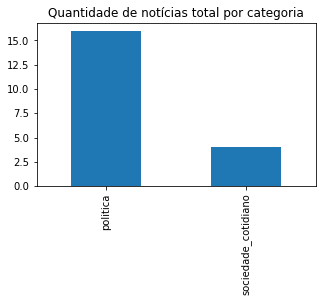

In [5]:
# Verificando assuntos

ax = complete_data['category'].value_counts().plot(kind='bar',
                                    figsize=(5,3),
                                    title="Quantidade de notícias total por categoria")

## Extraindo features

##### Bag-of-words
O Bag-of-words realiza uma contagem da quantidade de palavras existentes em um conjunto grande de textos. Para utilizar o efeito de considerar palavras com o mesmo significado, devemos pré-processar os textos e lematizar cada palavra.

In [7]:
# Carregando o pacote de língua portuguesa para o processador Spacy
nlp = spacy.load('pt_core_news_sm')

In [10]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [8]:
# Defininido funções de preprocessamento

def removePunct(text):
    '''
    Removes any punctuation included in string.punctuation.
    '''
    translator = text.maketrans({key:'' for key in string.punctuation}) # Translates any punctuation into ''
    return text.translate(translator)

def removeNumbers(text):
    '''
    Removes any number character in text.
    '''
    return re.sub('[0-9]', '' , text) # Translates any number into ''

def removeStopWords(string):
    '''
    Removes any portuguese stopwords, using Spacy's standard package.
    '''
    doc = nlp(string)
    return ' '.join([token.text for token in doc if token.is_stop is False])

def lemmatize(string):
    '''
    Lemmatizes text word-by-word. Notice that lemmatizing is not as harsh as stemming, which makes the final text easier to read and understand in common language.
    '''
    doc = nlp(string)
    return ' '.join([token.lemma_ for token in doc])

def prep(string, useStopWords = True, lemma = True):
    '''
    Executes previously defined preprocessing in text.
    '''

    result = removeNumbers(removePunct(string)).lower()
    
    if useStopWords and lemma:
        doc = nlp(result)
        result = ' '.join([token.lemma_ for token in doc if token.is_stop is False])
    elif useStopWords:
        doc = nlp(result)
        result = ' '.join([token.text for token in doc if token.is_stop is False])
    elif lemma:
        doc = nlp(result)
        result = ' '.join([token.lemma_ for token in doc])
    return result

In [9]:
text = '''Nós somos lá de São Carlos, viemos aqui pra zonear.
No esporte, nós somos bosta, nosso negócio é a cachaça. E mesmo, que nós não ganhe, que nós apanhe, vamos brindar.
A pinga, queremos com limãaaaaao. Mulheres, com muito mais tesãaaaaao. Se um dia a EESC amada precisar da macacada, puta merda, que cagada, 1,2,3,4.
Como é legal, calcular a integral. Mesmo sem grafite, calculamos o limite.'''

print(prep(text))

Carlos viemos pra zonear 
 esporte bosta negócio cachaça ganhe apanhar ir brindar 
 pinga querer limãaaaaao mulher tesãaaaaao dia eesc amar precisar macacada puta merdo cagar 
 legal calcular integral grafite calcular limite


In [10]:
text_news = '''A Petrobras anunciou nesta segunda-feira (9) que vai elevar o preço do diesel para as distribuidoras. O preço médio do litro vai passar de R$ 4,51 para R$ 4,91 a partir de terça (10), um aumento de 8,87%.

Os preços da gasolina e do gás de cozinha não serão alterados.

Segundo a petroleira, o diesel não sofria reajuste há 60 dias – desde 11 de março. Naquele momento, diz a Petrobras, a alta refletia "apenas parte da elevação observada nos preços de mercado".'''

print(prep(text_news))

petrobra anunciar segundafeira   elevar preço diesel distribuidora preço médio litro passar r   r   terça   aumento 

 preço gasolina gás cozinha ser alterar 

 petroleira diesel sofrer reajuste há   dia –   março petrobra alta refletir elevação observar preço mercado


In [11]:
def removeMinFreq(data, features, min_freq = 1):
    # Realiza a soma da frequência de cada palavra da matriz vetorizada
    cols_sum = np.sum(data, axis=0)

    del_indexes = []
    # Analisa cada valor das contagens de frequência do cols_sum, assignando um índice i, e salva o índice em del_indexes[]
    # quando a contagem for acima da min_freq
    for i, val in zip(range(len(cols_sum)), cols_sum):
        if val < min_freq:
            del_indexes.append(i)
            
    data = np.delete(data,del_indexes,1) # Deleta coluna
    features = np.delete(features,del_indexes,0) # Deleta linha
    return (data, features)


def normalizeData(data):
    rows_sum = np.sum(data, axis=1)
    data = (data.T / rows_sum).T
    return data


def loadCount(texts, min_freq = 1, binary = False, normalize = True):

    # Instanciando o CountVectorizer
    vectorizer = CountVectorizer(input = 'content', preprocessor = prep, encoding='utf-8', binary = binary);
    
    # Aplicando processo de vetorização
    data = np.array(vectorizer.fit_transform(text_list).todense());
    features = np.array(vectorizer.get_feature_names())
    
    # Se min_freq for 1, então todos os tokens são considerados
    if(min_freq > 1):
        data, features = removeMinFreq(data, features, min_freq)
    if(normalize):
        data = normalizeData(data)

    return pd.DataFrame(data,columns = features)

def loadTfidf(texts):

    # Instanciando o Tf-Idf como vetorizador
    vectorizer = TfidfVectorizer(input = 'content', preprocessor = prep, encoding='utf-8')
    
    data = np.array(vectorizer.fit_transform(texts).todense());
    features = np.array(vectorizer.get_feature_names())
    
    return pd.DataFrame(data,columns = features)

In [28]:
# Utilizando as funções definidas previamente, criamos dataframes para o bag-of-words (frequência geral e TF-IDF).

text_list = complete_data['texts'].to_list()

df_bow = loadCount(text_list, normalize = False)
df_tfidf = loadTfidf(text_list)

In [25]:
df_bow.shape

(20, 14)

In [27]:
df_bow

,Paulo,ano,bolsonaro,dia,dizer,fazer,federal,governo,partido,presidente,público,receber,ser,ter
0,0,0,0,0,0,0,2,0,3,0,0,1,1,1
1,0,2,0,0,1,1,0,0,0,0,0,0,1,0
2,2,1,0,1,3,0,0,0,3,2,0,0,0,0
3,0,0,0,2,0,0,0,0,0,0,0,3,0,0
4,3,1,0,0,0,1,0,2,0,1,0,0,2,1
5,0,1,0,0,2,0,2,1,0,1,2,0,1,0
6,0,2,0,4,0,1,0,0,0,0,4,1,2,0
7,0,5,0,2,1,0,0,3,1,2,3,1,1,0
8,0,0,0,0,0,1,3,1,0,0,2,0,0,0
9,2,4,9,2,2,2,4,1,7,4,0,2,0,2


## Treinando o modelo

In [29]:
#Módulos para modelagem de aprendizado de máquina tradicionais

# Viabilizadores
import joblib
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.utils import shuffle
from sklearn.pipeline import make_pipeline

# Algoritmos
from sklearn.svm import SVC #, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Feature selection & relatório de resultados
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report , confusion_matrix, accuracy_score

In [30]:
def assignVariables(df_features, df_complete_data):
    X = df_features.values
    y = df_complete_data['labels']
    
    return (X,y)

In [31]:
# Assignando variáveis dependentes e independentes e dividindo dados em conjunto de teste e treino

X,y = assignVariables(df_bow,complete_data)

test_size = 0.20

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=test_size, random_state=42)

In [19]:
X.shape

(20, 1368)

In [20]:
X_test.shape

(4, 1368)

### Selecione um algoritmo:
0 - Logistic Regression  
1 - Naive Bayes  
2 - Gradient Boosting  
3 - Random Forests  
4 - Support Vector Machine (SVM)  

In [24]:
y.shape

(20,)

In [32]:
classifier = [LogisticRegression(), MultinomialNB(), GradientBoostingClassifier(), RandomForestClassifier(), SVC()]

choice = input("Insira o ID do algoritmo a ser usado para treinamento do modelo: ")
save_model = int(input('''Salvar modelo?
0 - Não
1 - Sim
'''))

classifier = classifier[int(choice)]

feature_selection = 100

X_best = SelectKBest(mutual_info_classif,k=feature_selection).fit_transform(X,y)

predictions = (cross_val_predict(classifier, X_best, y, cv=5))

dataset_name = str(X.shape[0])+'_news'
if save_model==1:
    model_name = (classifier.__class__.__name__ + '_' + (dataset_name + '.pkl').lower())
    classifier.fit(X_best, y)
    joblib.dump(classifier,model_name)

target_name = ['Texto','Label']
print(classification_report(y, predictions, target_names=target_name))

Insira o ID do algoritmo a ser usado para treinamento do modelo: 0
Salvar modelo?
0 - Não
1 - Sim
0
              precision    recall  f1-score   support

       Texto       0.67      1.00      0.80        10
       Label       1.00      0.50      0.67        10

    accuracy                           0.75        20
   macro avg       0.83      0.75      0.73        20
weighted avg       0.83      0.75      0.73        20

